In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.sparse
import scipy.interpolate
import os
import pickle
import matplotlib.colors as mcolors
import sys
sys.path.append( "../../data_evaluation")
import handle_dictionaries
# sys.path.append("/Users/jkromer/Desktop/Projects/Stanford/pythonPackages/python_Scripts/evaluationScripts/")
# import spikeTrainAnalysis as sta

# generate figure from pre-evaluated data

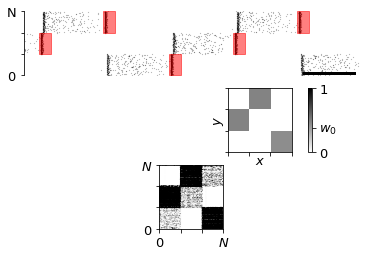

In [15]:
ticksFontsize = 13
labelFontsize = 15

parameters = {}
parameters[ 'seed' ] = 10
parameters[ 'ppb' ] = 1
parameters[ 'fCR' ] = 2.5 # Hz
parameters[ 'M' ] = 3
parameters[ 'de' ] = 20.0
parameters[ 'Astim' ] = 0.4


parameters[ 'Dalpha1' ] = 0.33
parameters[ 'Dalpha2' ] = 0.33

fig = plt.figure()
ax_spk1 = fig.add_subplot( 311 )
ax_wM = fig.add_subplot( 312 )
ax_wMTheory = fig.add_subplot( 313 )

plot_spiketrain_pulses_weights( parameters, ax_spk1, ax_wMTheory, ax_wM, False)



# plt.savefig('Fig12_a2.svg', bbox_inches='tight')
# plt.savefig('Fig12_a2.png', bbox_inches='tight')
# plt.savefig('Fig12_a2.pdf', bbox_inches='tight')
# plt.savefig('Fig12_a2.eps', bbox_inches='tight')

# functions

In [13]:
# parentDirectorySimData = '/Users/jkromer/Desktop/Projects/Stanford/scratch/'
# path to simulation data
parentDirectorySimData = '/Users/jkromer/Desktop/Projects/scratch/'

def J_phase_from_preevalData( phi, parSet, eta, td):

    #print(phi)
    if td != 3.0: # ms
        print('ERROR: no data for this delay found')

    #directory = '/Users/jkromer/Desktop/Projects/Stanford/paper/2021/Shifted periodic multisite stimulation/detailed theory/'
    #directory = '/Users/jkromer/Desktop/Projects/Stanford/paper/2022/PLoS CB Shifted periodic multisite stimulation/data_evaluation/pipe_line_sim-lambda-J/data_WofPhi/'
    directory = 'data/'
    
#     if sigma == 0.1:
#         print('choose parameter set el1')
#         J_phi_data = np.load( directory+'phi_el1.npz' )

#     if sigma == 0.6:
#         print('choose parameter set el2')
#         J_phi_data = np.load( directory+'phi_el2.npz' )

#     if sigma == 3.8:
#         print('choose parameter set vib1')
#         J_phi_data = np.load( directory+'phi_vib1.npz' )

#     if sigma == 7.2:
#         print('choose parameter set vib2')
#         J_phi_data = np.load( directory+'phi_vib2.npz' )

    if parSet['ppb']>1:
        filename = directory + 'normalized_phi_PLoS_intra_fCR_'+str(parSet['fCR'])+'_fintra_'+str(parSet['f_intra'])+'_Astim_'+str(parSet['Astim'])+'_de_'+str(parSet['de'])+'_ppb_'+str(parSet['ppb'])+'.npz'
    else:
        filename = directory + 'normalized_phi_PLoS_single_fCR_'+str(parSet['fCR'])+'_Astim_'+str(parSet['Astim'])+'_de_'+str(parSet['de'])+'_ppb_'+str(parSet['ppb'])+'.npz'
        # filename = '/Users/jkromer/Desktop/Projects/Stanford/paper/2021/PLoS CB Shifted periodic multisite stimulation/data_evaluation/pipe_line_sim-lambda-J/data_WofPhi/normalized_phi_PLoS_PLoS_single_fCR_5.0_Astim_0.4_de_1.0_ppb_1.npz'

    # load filename
    if os.path.isfile( filename ):

        J_phi_data = np.load( filename )

        STDP_type = 'aH'
        phi_data = J_phi_data[STDP_type][:,0]
        # get mean rate of weight change 
        # J_phi_data is estimated weight change per PMCS cycle
        J_data = eta*parSet['fCR']*(J_phi_data[STDP_type][:,1] + J_phi_data[STDP_type][:,2])

        J = np.interp(phi, phi_data , J_data)
    
    else:
        J = 0 
        print('WARNING:', filename ,'not found.')
        
    return J

# calculate matrix of phase differences
def phiMat( Da_vec ):
    
    M = len(Da_vec)+1
    phiMat = np.zeros( (M,M) )
    
    for kPost in range(1,M):
        for kPre in range(0,kPost):
            phiMat[ kPost, kPre ] = np.mod( np.sum( Da_vec[kPre:kPost] ) , 1 )
            phiMat[ kPre, kPost ] = np.mod( -np.sum( Da_vec[kPre:kPost] ), 1 )          
    return phiMat

# calculate matrix of estimated mean rate of weight change
def getJmat( phiMat , parSet):
    
    J_mat = np.zeros( phiMat.shape )

    #eta = 0.5 # phase lags * M
    td = 3.0 # ms synaptic transmission delay
    delta = 0.01 # STDP prefactor

    dtEval = 0.01 # ms
    tEval = np.arange(-1000.0,1000.0,dtEval)

    for x in range( len(J_mat) ):
        for y in range( len(J_mat) ):
            lag = np.mod(float(y-x),3)
            J_mat[x,y] = J_phase_from_preevalData( phiMat[y,x], parSet, delta, td)
    return J_mat



########### generate plots
# parameters[ 'seed' ] ... seed of initial network configuration
# parameters[ 'Dalpha1' ] ... phase shift between stimuli administered to first and second subpopulation
# parameters[ 'Dalpha2' ] ... phase shift between stimuli administered to second and third subpopulation
# parameters[ 'ppb' ] ... number of pulses per burst stimulus
# parameters[ 'fCR' ] ... stimulation frequency
# parameters[ 'M' ] ... number of subpopulations
# parameters[ 'de' ] ... pulse width
# parameters[ 'Astim' ] .. stimulus amplitude
def plot_spiketrain_pulses_weights( parameters, ax_spk, ax_weights, ax_weights_theory, labelsOff ):
    
    color_stimuli = 'red'
    
    # directory in which simulation data are stored
    # directory = '/Users/jkromer/Desktop/Projects/Stanford/scratch/Phase_shifted_periodic_multisite_stimulation/EL_phase_lags_TASS/'
    directory = parentDirectorySimData + 'Output/EL_phase_lags/'
    
    # evaluation time
    teval = 4000 # sec
    
    # filename of backup data set
    filename_dataSet = 'data/data_spk_weights_seed_'+str(parameters[ 'seed' ])+'_Dalpha1_'+str(parameters[ 'Dalpha1' ])+'_Dalpha2_'+str(parameters[ 'Dalpha2' ])+'_ppb_'+str(parameters[ 'ppb' ])+'_fCR_'+str(parameters[ 'fCR' ])+'_M_'+str(parameters[ 'M' ])+'_de_'+str(parameters[ 'de' ])+'_Astim_'+str(parameters[ 'Astim' ])+'_Tstim_1020.0_teval_'+str(teval)+'.npz'
    
    ##### load backup if backup already exists
    if os.path.isfile( filename_dataSet ) == False:
        print('WARNING:',filename_dataSet, 'not found')
        ### load original data and generate backup data
        # filenames for spike train and weight data
        filename_spk =          directory + 'initial_seed_'+str(parameters[ 'seed' ])+'/electrical_stimulation/multiple_spikes_phase_shifted_periodic_multisite_stimulation_TASS2012/Dalpha1_'+str(parameters[ 'Dalpha1' ])+'_Dalpha2_'+str(parameters[ 'Dalpha2' ])+'/pulses_per_burst_'+str(parameters[ 'ppb' ])+'/fCR_'+str(parameters[ 'fCR' ])+'_M_'+str(parameters[ 'M' ])+'_e_pulse_scale_'+str(parameters[ 'de' ])+'/Astim_'+str(parameters[ 'Astim' ])+'_Tstim_1020.0/spikeTimes_'+str(teval)+'_sec.npy'
        filename_weightMatrix = directory + 'initial_seed_'+str(parameters[ 'seed' ])+'/electrical_stimulation/multiple_spikes_phase_shifted_periodic_multisite_stimulation_TASS2012/Dalpha1_'+str(parameters[ 'Dalpha1' ])+'_Dalpha2_'+str(parameters[ 'Dalpha2' ])+'/pulses_per_burst_'+str(parameters[ 'ppb' ])+'/fCR_'+str(parameters[ 'fCR' ])+'_M_'+str(parameters[ 'M' ])+'_e_pulse_scale_'+str(parameters[ 'de' ])+'/Astim_'+str(parameters[ 'Astim' ])+'_Tstim_1020.0/'+str(teval)+'_sec/cMatrix.npz'

        # load simulation data
        if os.path.isfile( filename_spk ):
            spk_data = np.load( filename_spk )
            if os.path.isfile( filename_weightMatrix ):
                wMatrix = scipy.sparse.load_npz( filename_weightMatrix )
            
                # generate backup filename   
                np.savez( filename_dataSet , spk_train = spk_data , wMatrix = wMatrix.A )
                print('writing',filename_dataSet )
            else:
                print('WARNING:', filename_weightMatrix, 'not found')
        else:
            print('WARNING:', filename_spk, 'not found')
   
        

    plotRange = [teval - 0.7, teval-0.01]
    
    # load data set
    if os.path.isfile( filename_dataSet ):
        dataSet =  np.load( filename_dataSet, allow_pickle=True )

        ################################################
        ###### plot results
        ################################################
        # plot spike train
        t   = dataSet['spk_train'][:,1]*0.1*0.001 # sec
        ind = dataSet['spk_train'][:,0]

        t_plot   = t[ np.logical_and( t > plotRange[0]-1.0/parameters[ 'fCR' ], t < plotRange[1] ) ]
        ind_plot = ind[ np.logical_and( t > plotRange[0]-1.0/parameters[ 'fCR' ], t < plotRange[1] ) ]

        ax_spk.scatter( t_plot , ind_plot, color='black', s = 0.01, zorder = 2 )
        
    ### plot stimuli
    # stimulation times of individual subpopulations
    tStim_1 = np.arange( 3000.0, teval, 1.0/parameters[ 'fCR' ] ) # sec
    tStim_2 = tStim_1 +  parameters[ 'Dalpha1' ]/parameters[ 'fCR' ]
    tStim_3 = tStim_2 +  parameters[ 'Dalpha2' ]/parameters[ 'fCR' ]
    # restrict to plot range
    tStim_1 = tStim_1[ np.logical_and( tStim_1 > plotRange[0]-1.0/parameters[ 'fCR' ], tStim_1 <= plotRange[1]+0.01 ) ]
    tStim_2 = tStim_2[ np.logical_and( tStim_2 > plotRange[0]-1.0/parameters[ 'fCR' ], tStim_2 <= plotRange[1]+0.01 ) ]
    tStim_3 = tStim_3[ np.logical_and( tStim_3 > plotRange[0]-1.0/parameters[ 'fCR' ], tStim_3 <= plotRange[1]+0.01 ) ]
    #print(tStim_1)
    # plot stimulus trains for individual subpopulations
    for tStim in tStim_1:
        ax_spk.fill_between( [np.round( tStim,3 ),np.round( tStim + 0.0012*parameters[ 'de' ],3 )], y1=333, y2=0, color = color_stimuli, alpha=0.5,zorder = 3)
        
        #ax_spk.plot( [tStim,tStim] , [0,333] , lw = 3, color = 'red', zorder = 1 )                      
    for tStim in tStim_2:
        ax_spk.fill_between( [np.round( tStim,3 ),np.round( tStim + 0.0012*parameters[ 'de' ],3 )], y1=666, y2=333, color = color_stimuli,alpha=0.5, zorder = 3)
        #ax_spk.plot( [tStim,tStim] , [333,666] , lw = 3, color = 'red', zorder = 1 )
    for tStim in tStim_3:
        #ax_spk.plot( [tStim,tStim] , [666,999] , lw = 3, color = 'red', zorder = 1 )
        ax_spk.fill_between( [np.round( tStim,3 ),np.round( tStim + 0.0012*parameters[ 'de' ],3 )], y1=999, y2=666, color = color_stimuli, alpha=0.5, zorder = 3)

    
    ax_spk.set_yticks([0,333,666,1000])
    ax_spk.set_yticklabels(['$0$','','','N'], fontsize = ticksFontsize )
    ax_spk.set_xticks([])
    ax_spk.set_xticklabels([], fontsize = ticksFontsize )
    
    ax_spk.plot( [teval-0.12, teval-0.02], [20,20], color='black', lw=4, zorder = 5 )
    
    ax_spk.set_xlim( plotRange )
    ax_spk.set_ylim( 0 , 1000)

    ax_spk.spines['top'].set_visible(False)
    ax_spk.spines['bottom'].set_visible(False)
    ax_spk.spines['right'].set_visible(False)
    
    ################################################
    # plot weight matrix
    if os.path.isfile( filename_dataSet ):
        cMatrix = scipy.sparse.csc_matrix( dataSet[ 'wMatrix' ] ) 

        ind = np.nonzero(cMatrix)

        #ax_weights.scatter( ind[0], ind[1] , c=np.array(cMatrix[  ind ])[0,:], vmin=0, vmax=1, cmap = 'gray_r' , s=0.1)
        ax_weights.scatter( ind[1], ind[0] , c=np.array(cMatrix[  ind ])[0,:], vmin=0, vmax=1, cmap = 'gray_r' , s=0.1)

    ax_weights.set_xticks([0,333,666,999])
    ax_weights.set_yticks([0,333,666,999])
    # ax_weights.set_xticklabels(['$0$','','','$N$'], fontsize = ticksFontsize)
    
    if labelsOff==True:
        ax_weights.set_yticklabels(['$0$','','','$N$'], fontsize = ticksFontsize)
        ax_weights.set_xticklabels(['','','',''], fontsize = ticksFontsize)
    else:
        ax_weights.set_yticklabels(['$0$','','','$N$'], fontsize = ticksFontsize)
        ax_weights.set_xticklabels(['$0$','','','$N$'], fontsize = ticksFontsize)

    ax_weights.set_yticks([0,333,666,999])
    ax_weights.set_aspect(1)
    
    ax_weights.set_xlim( 0, 999)
    ax_weights.set_ylim( 0, 999)
    
    ################################################
    # plot theoretical prediction for weight matrix
    # get weight matrix
    Jmat = getJmat( phiMat( [ parameters[ 'Dalpha1' ] , parameters[ 'Dalpha2' ] ] ) , parameters)
    w0=0.38
    t = 1000.0 # sec
    wMatrix = np.zeros( Jmat.shape )
    wMatrix[ Jmat<0 ]+=w0 + w0*t*Jmat[ Jmat<0 ]
    wMatrix[ Jmat>0 ]+=w0 + (1-w0)*t*Jmat[ Jmat>0 ]
    wMatrix = np.clip( wMatrix , a_min=0, a_max=1 )
    
    #ax_weights_theory.imshow( np.sign( Jmat )   , vmin=0, vmax=1, cmap = 'gray_r', origin='lower'  )
    cax = ax_weights_theory.imshow( np.transpose( wMatrix )   , vmin=0, vmax=1, cmap = 'gray_r', origin='lower'  )
    cbar= plt.colorbar( cax , ax=ax_weights_theory, ticks=[0,  0.38, 1] )
    cbar.ax.set_yticklabels( ['$0$',   '$w_0$','$1$'] , fontsize= ticksFontsize )
    # cbar.set_label( '$\\mathcal{W}_{xy}$' , fontsize=labelFontsize)    
    
    
    
    ax_weights_theory.set_xticks([-0.5, 0.5,1.5,2.5])
    ax_weights_theory.set_yticks([-0.5, 0.5,1.5,2.5])
 
    ax_weights_theory.set_xticklabels(['', '','',''], fontsize = ticksFontsize)
    ax_weights_theory.set_yticklabels(['', '','',''], fontsize = ticksFontsize)
   
    ax_weights_theory.set_xlabel('$x$', fontsize = ticksFontsize, labelpad=-5)
    ax_weights_theory.set_ylabel('$y$', fontsize = ticksFontsize, labelpad=-5)

    if os.path.isfile( filename_dataSet ):
        return dataSet
    else:
        return 0